<h3>This model takes in an image of a peice of clothing and recognizes it</h3>

<h1>Getting the Environment Set Up</h1>

Import Dependencies

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

Configure cuda/gpu if available

GPU boost training time. Why? Because it lets us do hundreds to thousands of calculations at the same time

torch.device docs - https://pytorch.org/docs/stable/tensor_attributes.html#torch-device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h1>Managing our Images</h1>

transforms docs - https://pytorch.org/vision/stable/transforms.html

In [ ]:
# Convert Data to Tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

datasets docs - https://pytorch.org/vision/stable/datasets.html

In [ ]:
# parameters
input_size = 28 # 28 * 28
num_classes = 10 # 10 labels
num_epochs = 10 # 10 training iterations
batch_size = 8

# training set
train_dataset = torchvision.datasets.FashionMNIST(
    root = "./data",
    train = True,
    transform = transform,
    download = True
)

# testing set
test_dataset = torchvision.datasets.FashionMNIST(
    root = "./data",
    train = False,
    transform = transform,
    download = True
)

# Get batched Dataloaders
trainloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True # optional
)

testloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = True # optional
)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

Visualize our data

matplotlib docs - https://matplotlib.org/stable/users/index

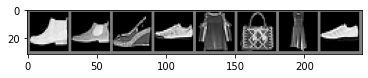

Ankle boot Ankle boot Sandal Sneaker Shirt Bag   Dress Sneaker


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##### H2 = size of height after convolution
##### W2 = size of width after convolution
##### H1 = primitive height size
##### FH = filter's height size
##### W1 = primitive width size
##### WH = filter's width size
##### P = num padding
##### S = stride

#####H2 = (H1 - FH + 2P)/S + 1
#####W2 = (W1 - FW + 2P)/S + 1

<h1>Creating Our Model</h1>

Data format: [batch_size, 1(grey, 3 if RGB but not applicable here), 28, 28]

Module docs - https://pytorch.org/docs/stable/generated/torch.nn.Module.html <br> nn docs - https://pytorch.org/docs/stable/nn.html

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__() 
    self.conv_layer_1 = nn.Sequential( # input.shape: [batch, 1, 28, 28]
        nn.Conv2d(
            in_channels=1, # grey scale, 3 otherwise if RGB   
            out_channels=16, # 16 x 1(grey scale, 3 otherwise if RGB ) filters
            kernel_size=5, # convolution extraction size
            stride=1,
            padding=2 # for convoluted output to be same size,
                      # need padding=(kernel_size-1)/2 if stride = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # (2x2 maxpool), out.shape: [16, 14, 14]
    )
    self.conv_layer_2 = nn.Sequential( # input.shape: [batch, 16, 14, 14]
        nn.Conv2d(
            in_channels=16,
            out_channels=32, # 32 filters
            kernel_size=5,
            stride=1,
            padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # (2x2 maxpool), out.shape: [32, 7, 7]
    )
    self.fc = nn.Linear(32*7*7, 10)

  def forward(self, x):
    # x.shape: [batch_size, 1, 28, 28] -> [batch_size, 16, 14, 14]
    x = self.conv_layer_1(x)
    # x.shape: [batch_size, 16, 14, 14] -> [batch_size, 32, 7, 7]
    x = self.conv_layer_2(x)
    x = x.view(x.shape[0], -1) # flatten: [batch_size, 32*7*7]
    # x.shape: [batch_size, 32*7*7] -> [batch_size, 10]
    out = self.fc(x)
    return out

optim docs - https://pytorch.org/docs/stable/optim.html

In [ ]:
model = CNN()
model.to(device) # cast model to device

criterion = nn.CrossEntropyLoss()
criterion.to(device) # cast loss function to device

optimizer = optim.Adam(model.parameters(), lr=0.001)

<h1>Training our Model</h1>

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device) # cast input to device
        labels = labels.to(device) # cast output to device

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 3750 == 3749:    # print every 3750 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 3750:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  3750] loss: 0.458
[1,  7500] loss: 0.330
[2,  3750] loss: 0.288
[2,  7500] loss: 0.279
[3,  3750] loss: 0.259
[3,  7500] loss: 0.254
Finished Training


<h1>Evaluating our Model</h1>

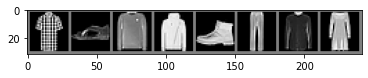

GroundTruth:  Shirt Sandal Pullover Coat  Ankle boot Trouser Shirt Dress


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 92 %


<h1>Using our Model</h1>

Ground Truth: Trouser


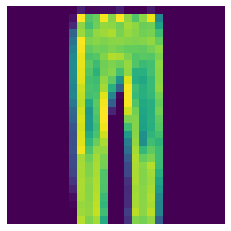

In [ ]:
import random
rand = random.randint(0,9999)
image = test_dataset[rand][0] # shape: [(1) batch_size, 28, 28]
plt.subplot()
plt.axis('off')
# [1, 28, 28] -> [28, 28]
plt.imshow(image.squeeze(0))
print(f"Ground Truth: {classes[test_dataset[rand][1]]}")

In [ ]:
with torch.no_grad():
    # cast input to device
    # [(1), 28, 28] -> [(1), (1), 28, 28]
    image = image.to(device)

    log_preds = model(image.unsqueeze(0))

# post processes the image into probabilities of it being each digit
#   Math: probabilites were natural logged, so torch.exp() performs e^(log_preds)
preds = torch.exp(log_preds)
probab = list(preds.cpu().numpy()[0])
pred_label = probab.index(max(probab)) # get index of max num (highest probability)

print(f"Prediction: {classes[pred_label]}")

Prediction: Trouser
